In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import pickle

In [5]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'

In [14]:
eng_feats = pd.read_pickle(os.path.join(data_dir, 'clean_data/engineered_features/fire_hist_features.pkl'))
eng_feats.rename(columns = {'total_fire_days_x': 'total_fire_days', 'hist_p_time_1y_x':'hist_p_time_1y'}, inplace = True)
eng_feats.to_pickle(os.path.join(data_dir, 'clean_data/engineered_features/fire_hist_features.pkl'))

In [72]:
weather_data = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_weather_data.pkl'))
weather_data[[i for i in weather_data.columns if str.find(i,'2 metre')>-1]].describe()

,2 metre dewpoint temperature hrs:0,2 metre temperature hrs:0,2 metre dewpoint temperature hrs:6,2 metre temperature hrs:6,2 metre dewpoint temperature hrs:12,2 metre temperature hrs:12,2 metre dewpoint temperature hrs:18,2 metre temperature hrs:18
count,48576.000000,48576.000000,48576.000000,48576.000000,48576.000000,48576.000000,48576.000000,48576.000000
mean,276.030689,291.682098,277.114079,285.244190,276.503002,282.442216,276.006806,289.430157
std,5.756053,8.914737,5.930448,7.917574,6.084439,6.979511,5.724173,8.410866
min,258.307751,267.044663,256.874512,263.387796,254.807651,261.364965,256.166332,263.808187
25%,271.735738,285.704403,273.057296,280.143290,272.471053,278.054818,271.875581,283.500224
50%,276.485210,291.189290,277.762109,285.102959,277.111070,282.431999,276.465817,289.344134
75%,280.369618,298.130550,281.476196,290.612081,280.932468,287.337333,280.242383,295.953788
max,291.473633,313.928641,292.119629,308.627507,292.120171,303.589209,291.338135,309.847803


In [70]:
target_df = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_geo.pkl'))
target_df.describe()

,GRID_ID,YEAR,MONTH,COUNTYFP,GRID_AREA,COUNTY_ARE,Y_bin,Y_fire_class_size,Y_fire_count,Fire_area,...,Surface pressure hrs:12,Total precipitation hrs:12,10 metre U wind component hrs:18,10 metre V wind component hrs:18,2 metre dewpoint temperature hrs:18,2 metre temperature hrs:18,"Leaf area index, high vegetation hrs:18","Leaf area index, low vegetation hrs:18",Surface pressure hrs:18,Total precipitation hrs:18
count,35733.000000,35733.000000,35733.000000,35733.000000,3.573300e+04,3.573300e+04,35733.000000,35733.000000,35733.000000,3.573300e+04,...,35733.000000,3.573300e+04,35733.000000,35733.000000,35733.000000,35733.000000,35733.000000,35733.000000,35733.000000,3.573300e+04
mean,75.902107,2004.503008,6.515238,56.321971,4.537280e+09,2.219139e+10,0.108471,0.228220,0.187866,4.005290e+06,...,91654.929576,8.217999e-04,0.487142,0.217151,275.632303,289.433539,2.348558,1.193621,91770.392080,1.235061e-03
std,46.597356,8.632085,3.444702,31.009200,1.117092e+09,1.965293e+10,0.310979,0.754216,0.765706,4.417485e+07,...,6262.900418,1.351111e-03,0.826254,0.801147,5.599808,8.440839,1.353853,0.693053,6274.745857,2.025946e-03
min,0.000000,1990.000000,1.000000,1.000000,9.325053e+08,2.562528e+09,0.000000,0.000000,0.000000,0.000000e+00,...,73537.562500,1.714898e-07,-2.016808,-3.829790,256.166332,263.808187,0.000000,0.024249,73622.712500,3.320812e-07
25%,37.000000,1997.000000,4.000000,29.000000,5.000733e+09,7.492856e+09,0.000000,0.000000,0.000000,0.000000e+00,...,87705.729167,3.286537e-05,-0.085085,-0.268096,271.568644,283.223772,1.708643,0.540334,87816.263889,5.682434e-05
50%,66.000000,2004.000000,7.000000,53.000000,5.041000e+09,1.738808e+10,0.000000,0.000000,0.000000,0.000000e+00,...,91763.991071,2.473255e-04,0.385402,0.212174,275.768464,289.378662,2.517645,1.088755,91894.858333,3.864345e-04
75%,120.000000,2012.000000,10.000000,79.000000,5.041000e+09,2.941902e+10,0.000000,0.000000,0.000000,0.000000e+00,...,97275.321429,9.963614e-04,0.980531,0.727225,279.693701,296.153288,3.355879,1.722641,97384.762500,1.486302e-03
max,147.000000,2019.000000,12.000000,111.000000,5.041000e+09,7.749300e+10,1.000000,4.000000,31.000000,1.651920e+09,...,101988.095833,1.331524e-02,5.048863,3.249624,291.338135,309.847803,5.172008,2.757053,102153.995833,2.056689e-02


In [84]:
target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_geo_1121_weathereng_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_geo_1121_weathereng_2.pkl'))
target_df = target_df1.append(target_df2)

In [76]:
feat_dist = target_df.describe()
feat_dist.to_csv(os.path.join(data_dir, 'clean_data/feature_distributions.csv'))

In [75]:
feat_dist.describe()

,GRID_ID,YEAR,MONTH,COUNTYFP,GRID_AREA,COUNTY_ARE,Y_bin,Y_fire_class_size,Y_fire_count,Fire_area,...,Surface pressure hrs:12,Total precipitation hrs:12,10 metre U wind component hrs:18,10 metre V wind component hrs:18,2 metre dewpoint temperature hrs:18,2 metre temperature hrs:18,"Leaf area index, high vegetation hrs:18","Leaf area index, low vegetation hrs:18",Surface pressure hrs:18,Total precipitation hrs:18
count,8.000000,8.000000,8.000000,8.000000,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000,8.000000e+00,...,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000e+00
mean,4528.187433,5971.016887,4472.119993,4511.666396,3.338831e+09,2.202498e+10,4466.802431,4467.247805,4470.619196,2.125170e+08,...,73240.191249,4.466627e+03,4467.328287,4466.763679,4673.595923,4684.160761,4468.682073,4467.627463,73331.341374,4.466628e+03
std,12608.733391,12045.922158,12631.303493,12615.367988,2.228530e+09,2.459267e+10,12633.451618,12633.271729,12631.914020,5.818074e+08,...,34202.026564,1.263352e+04,12633.239288,12633.467420,12550.252292,12546.015296,12632.692213,12633.118277,34255.417475,1.263352e+04
min,0.000000,8.632085,1.000000,1.000000,3.573300e+04,3.573300e+04,0.000000,0.000000,0.000000,0.000000e+00,...,6262.900418,1.714898e-07,-2.016808,-3.829790,5.599808,8.440839,0.000000,0.024249,6274.745857,3.320812e-07
25%,44.198017,1995.250000,3.861176,30.506900,1.070946e+09,6.260274e+09,0.000000,0.000000,0.000000,0.000000e+00,...,64086.421875,1.937105e-04,0.267780,0.092106,267.718066,278.369876,1.619945,0.654873,64150.284375,3.040319e-04
50%,70.951054,2004.251504,6.757619,54.660986,4.769006e+09,1.852051e+10,0.054236,0.114110,0.093933,1.786650e+04,...,89680.329371,9.090807e-04,0.656698,0.472188,275.700384,289.406101,2.433102,1.141188,89793.327985,1.360682e-03
75%,126.750000,2013.750000,10.500000,87.000000,5.041000e+09,2.399830e+10,0.483234,1.565662,8.324279,1.404768e+07,...,93141.823661,4.342144e-03,1.997614,1.413266,282.604810,299.576917,3.809911,1.981244,93267.334375,6.661181e-03
max,35733.000000,35733.000000,35733.000000,35733.000000,5.041000e+09,7.749300e+10,35733.000000,35733.000000,35733.000000,1.651920e+09,...,101988.095833,3.573300e+04,35733.000000,35733.000000,35733.000000,35733.000000,35733.000000,35733.000000,102153.995833,3.573300e+04


In [55]:
for col in target_df.columns:
    if col[-2:]=="_y":
        target_df.rename(columns= {col: col[:-2]}, inplace = True)

In [57]:
target_df.drop(['total_fire_days_x', 'hist_p_time_1y_x'],axis = 1, inplace = True)

In [11]:
non_mod_cols = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size']

In [26]:
prob_cols = ['10 metre V wind component hrs:6', '2 metre dewpoint temperature hrs:12', 'Leaf area index, low vegetation hrs:6']

NameError: name 'train_data' is not defined

## Binary Target Variable

In [16]:
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train_bin = train_data['Y_bin']

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test_bin = test_data['Y_bin'] 

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Random forest

In [49]:
cw = compute_class_weight('balanced', [0,1], Y_train_bin)
bin_weights = {0: 0.55757964, 1:100}

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0, 1], y=0        0
1        0
2        0
3        0
4        0
        ..
35692    0
35693    0
35694    0
35695    0
35696    0
Name: Y_bin, Length: 32169, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [56]:
rf_clf_bin_bal = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced_subsample').fit(X_train, Y_train_bin)

In [57]:
y_preds_rf_bin = rf_clf_bin_bal.predict(X_test)
y_proba_rf_bin = rf_clf_bin_bal.predict_proba(X_test)[:,1]

In [58]:
feat_import = pd.DataFrame()
feat_import['col'] = X_train.columns
feat_import['feature_importance'] = rf_clf_bin_bal.feature_importances_
feat_import.sort_values(['feature_importance'], ascending = False)

,col,feature_importance
62,hist_bin_1m,0.039660
66,Y_fire_class_size_prev_month,0.039552
70,Y_fire_area_prop_prev_month,0.034717
73,Y_fire_area_prop_prev_10yr,0.029510
28,adj_fire_count,0.028095
...,...,...
129,leaf_low_veg_12hrs_5y,0.001411
4,elev_min,0.001377
95,leaf_low_veg_0hrs_1y,0.001329
8,road_count,0.001266


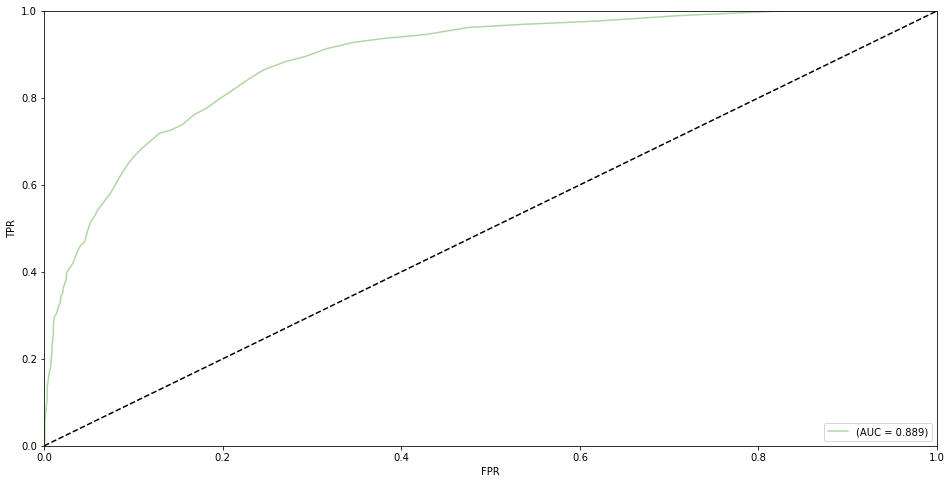

In [59]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_bal, tpr_bal, threshold = roc_curve(Y_test_bin, y_proba_rf_bin)
c = (np.random.rand(), np.random.rand(), np.random.rand())
roc_auc = auc(fpr_bal, tpr_bal)
plt.plot(fpr_bal, tpr_bal, color = c, label = '(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

In [60]:
print(pd.DataFrame(confusion_matrix(Y_test_bin, y_preds_rf_bin, normalize = 'true', labels = [0,1]), \
                   columns = ['0', '1'], index = ['0','1']))

          0         1
0  0.990365  0.009635
1  0.756318  0.243682


In [95]:
corr_cols = list(X_train.columns)
corr_cols.append('Y_fire_class_size')
corr_cols.append('Y_bin')
print(corr_cols)
X_train_corr = np.corrcoef(target_df[corr_cols].transpose())

['elev_mean', 'elev_std', 'elev_media', 'elev_max', 'elev_min', 'elev_range', 'pl_count', 'total_pl_length', 'road_count', 'total_road_length', 'MEDIAN_AGE_TOT', 'MEDIAN_AGE_MALE', 'MEDIAN_AGE_FEM', 'AGEUNDER13_TOT', 'AGE1424_TOT', 'AGE2544_TOT', 'AGE4564_TOT', 'AGE65PLUS_TOT', 'POPDENSITY', 'POPDENSITY_MALE', 'POPDENSITY_FEM', 'Structure Arsons', 'Mobile Arsons', 'Other Arsons', 'Total Arsons', 'Total Arsons Cleared', 'Unemployment', 'medianHHI2018', 'adj_fire_count', 'adj_fire_bcount', '10 metre U wind component hrs:0', '10 metre V wind component hrs:0', '2 metre dewpoint temperature hrs:0', '2 metre temperature hrs:0', 'Leaf area index, high vegetation hrs:0', 'Leaf area index, low vegetation hrs:0', 'Surface pressure hrs:0', 'Total precipitation hrs:0', '10 metre U wind component hrs:6', '10 metre V wind component hrs:6', '2 metre dewpoint temperature hrs:6', '2 metre temperature hrs:6', 'Leaf area index, high vegetation hrs:6', 'Leaf area index, low vegetation hrs:6', 'Surface pre

In [97]:
print(X_train_corr.shape)
X_train_corr_df = pd.DataFrame(X_train_corr, columns = corr_cols, index = corr_cols)
X_train_corr_df.to_csv(os.path.join(data_dir, 'model_outputs/X_train_correlation_matrix.csv'))

(173, 173)


In [170]:
feat_import = pd.DataFrame()
feat_import['col'] = X_train.columns
feat_import['feature_importance'] = rf_clf_bin_bal.feature_importances_
feat_import.sort_values(['feature_importance'], ascending = False)

,col,feature_importance
66,Y_fire_class_size_prev_month,0.049443
70,Y_fire_area_prop_prev_month,0.043419
28,adj_fire_count,0.042859
62,hist_bin_1m,0.041139
57,2 metre temperature hrs:18,0.035145
...,...,...
6,pl_count,0.003963
2,elev_media,0.003817
8,road_count,0.003573
9,total_road_length,0.003375


#### Investigate data

In [64]:
feat_dist = X_train.describe()
feat_dist.columns = sorted(feat_dist.columns) 
feat_dist.to_csv(os.path.join(data_dir, 'clean_data/feature_distributions.csv'))

In [173]:
compare_df = Y_test.copy()
compare_df['Y_class_size_pred'] = y_preds_class_size
len(compare_df[(compare_df['Y_class_size_pred']==compare_df['Y_fire_class_size']) & (compare_df['Y_fire_class_size']>0)])

43

In [178]:
len(compare_df[(compare_df['Y_class_size_pred']>0) & (compare_df['Y_fire_class_size']==0)])/554

0.18050541516245489

In [182]:
rf_clf_bin = RandomForestClassifier().fit(X_train, Y_train)

<ipython-input-182-d718253a84e7>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf_bin = RandomForestClassifier().fit(X_train, Y_train)


In [183]:
y_preds_bin = rf_clf.predict(X_test)

In [187]:
y_bin_probs = rf_clf.predict_proba(X_test)[:,1]

In [186]:
tab = dict(zip([0,1,2,3,4],[0,1,2,3,4]))
y_eval = np.vectorize(tab.get)(Y_test)
y_eval = y_eval.reshape(3564)
y_pred = np.vectorize(tab.get)(y_preds_bin)
# Making the Confusion Matrix
print(pd.crosstab(y_eval, y_pred, rownames=['Actual Classes'], colnames=['Predicted Classes']))

Predicted Classes     0    1
Actual Classes              
0                  2837  173
1                   380  174


In [119]:
X_train_samp[i].columns.tolist()

['elev_mean',
 'elev_std',
 'elev_media',
 'elev_max',
 'elev_min',
 'elev_range',
 'pl_count',
 'total_pl_length',
 'road_count',
 'total_road_length',
 'MEDIAN_AGE_TOT',
 'MEDIAN_AGE_MALE',
 'MEDIAN_AGE_FEM',
 'AGEUNDER13_TOT',
 'AGE1424_TOT',
 'AGE2544_TOT',
 'AGE4564_TOT',
 'AGE65PLUS_TOT',
 'POPDENSITY',
 'POPDENSITY_MALE',
 'POPDENSITY_FEM',
 'Structure Arsons',
 'Mobile Arsons',
 'Other Arsons',
 'Total Arsons',
 'Total Arsons Cleared',
 'Unemployment',
 'medianHHI2018',
 '10 metre U wind component hrs:0',
 '10 metre V wind component hrs:0',
 '2 metre dewpoint temperature hrs:0',
 '2 metre temperature hrs:0',
 'Leaf area index, high vegetation hrs:0',
 'Leaf area index, low vegetation hrs:0',
 'Surface pressure hrs:0',
 'Total precipitation hrs:0',
 '10 metre U wind component hrs:6',
 '10 metre V wind component hrs:6',
 '2 metre dewpoint temperature hrs:6',
 '2 metre temperature hrs:6',
 'Leaf area index, high vegetation hrs:6',
 'Leaf area index, low vegetation hrs:6',
 'Surfac

In [121]:
train_data = target_df[target_df['YEAR']<=2016]
train_samp = {}
X_train_samp = {}
Y_train_samp = {}
for i in np.arange(0.1, 1, 0.1):
    train_samp[i] = train_data[train_data['Y_bin']==1].append(train_data[train_data['Y_bin']==0].sample(frac=i))
    X_train_samp[i] = train_samp[i].drop('YEAR', axis = 1)
    print(len(X_train_samp[i][X_train_samp[i]['Y_bin']==0])/len(X_train_samp[i]))
    for y in Y_cols + non_mod_cols:
        try:
            X_train_samp[i].drop(y, inplace = True, axis =1)
        except:
            pass
    Y_train_samp[i] = train_samp[i][['Y_bin']]
    print(X_train_samp[i].shape)

0.4647978089254068
(6207, 73)
0.6345836541634584
(9091, 73)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0.7226118904475618
(11976, 73)
0.7764618800888231


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(14861, 73)
0.8128028851572185
(17746, 73)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0.8389723703344644
(20630, 73)
0.8587284711886031
(23515, 73)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0.8741666666666666
(26400, 73)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0.8865592132222374
(29284, 73)


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [122]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data['Y_fire_area_prop']

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [123]:
rf_reg = {}
for i in X_train_samp.keys():
    print(i)
    rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])

0.1


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.2


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.30000000000000004


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.4


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.5


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.6


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.7000000000000001


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.8


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


0.9


<ipython-input-123-d46d01370da5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg[i] = RandomForestRegressor().fit(X_train_samp[i], Y_train_samp[i])


In [124]:
y_preds_reg = {}
y_proba_reg = {}
for i in rf_reg.keys():
    y_preds_reg[i] = rf_reg[i].predict(X_test)

R^2 value: -1261.3173678764656


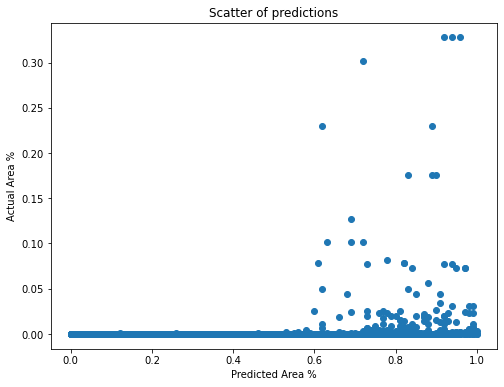

R^2 value: -882.0007155902003


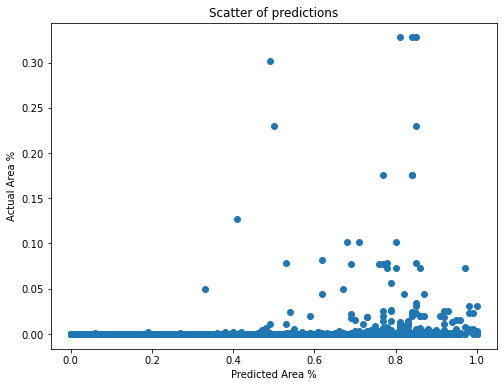

R^2 value: -699.5287401336565


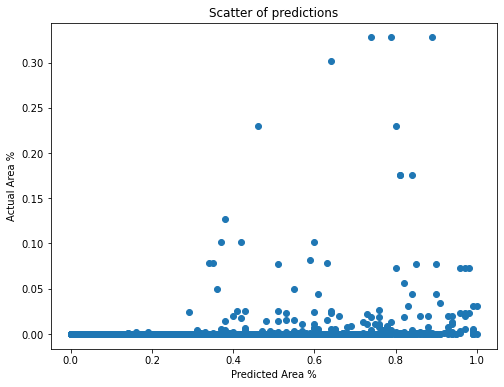

R^2 value: -594.2180945821456


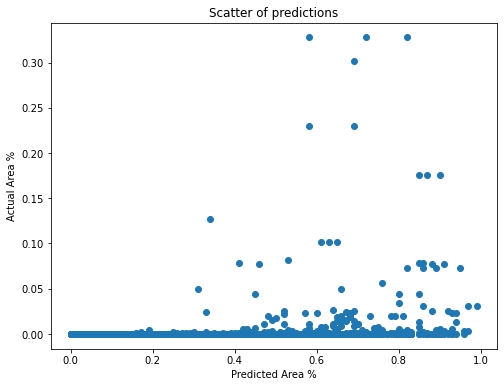

R^2 value: -516.3105764271176


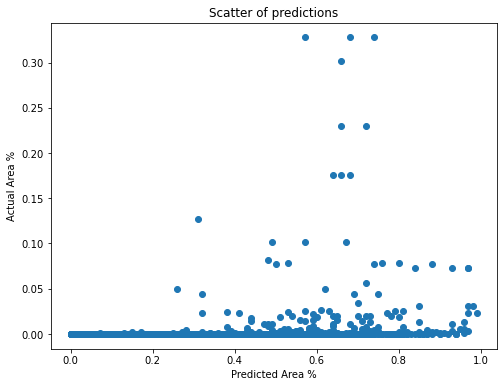

R^2 value: -474.9539346155356


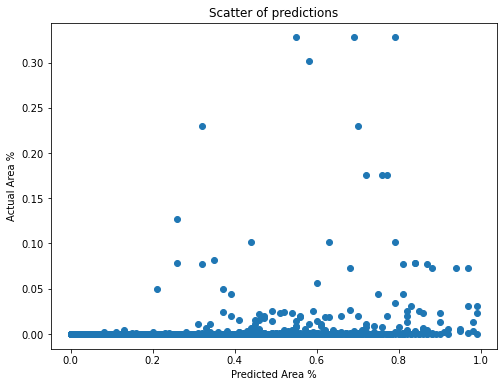

R^2 value: -434.2683954525909


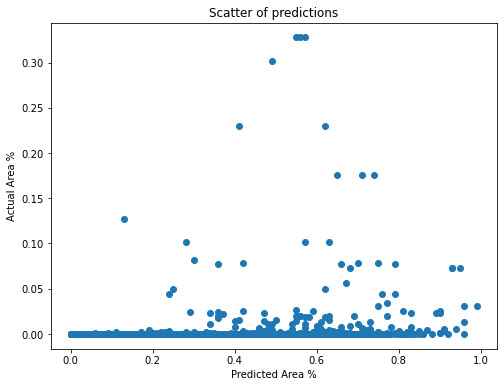

R^2 value: -384.85036742364497


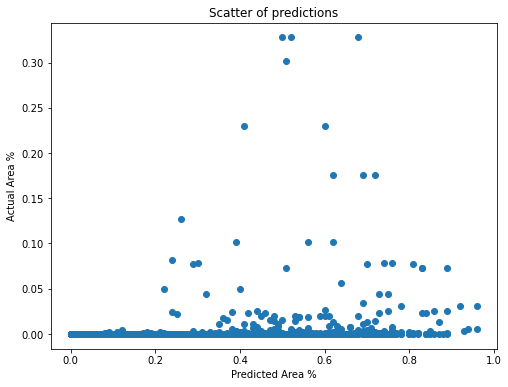

R^2 value: -353.2764510016237


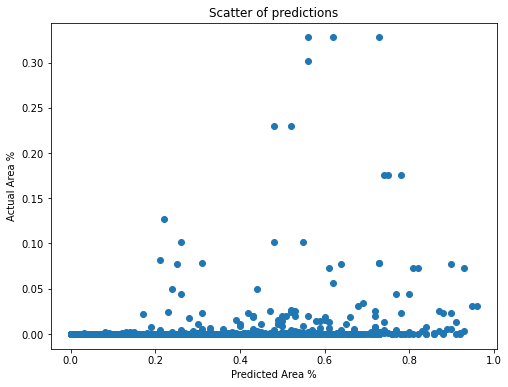

In [125]:
#plot predictions vs actuals
for i in X_train_samp.keys():
    plt.figure(figsize=(8,6))
    plt.scatter(y_preds_reg[i], Y_test)
    plt.title('Scatter of predictions')
    plt.xlabel('Predicted Area %')
    plt.ylabel('Actual Area %')
    #check R^2 value
    print("R^2 value:",rf_reg[i].score(X_test, Y_test))
    #print("MSE:",round(mean_squared_error(y_test_arr, preds_arrays),3))
    plt.show()

In [200]:
X_train.columns.tolist()

['elev_mean',
 'elev_std',
 'elev_media',
 'elev_max',
 'elev_min',
 'elev_range',
 'pl_count',
 'total_pl_length',
 'road_count',
 'total_road_length',
 'MEDIAN_AGE_TOT',
 'MEDIAN_AGE_MALE',
 'MEDIAN_AGE_FEM',
 'AGEUNDER13_TOT',
 'AGE1424_TOT',
 'AGE2544_TOT',
 'AGE4564_TOT',
 'AGE65PLUS_TOT',
 'POPDENSITY',
 'POPDENSITY_MALE',
 'POPDENSITY_FEM',
 'Structure Arsons',
 'Mobile Arsons',
 'Other Arsons',
 'Total Arsons',
 'Total Arsons Cleared',
 'Unemployment',
 'medianHHI2018',
 'adj_fire_count',
 'adj_fire_bcount',
 '10 metre U wind component hrs:0',
 '10 metre V wind component hrs:0',
 '2 metre dewpoint temperature hrs:0',
 '2 metre temperature hrs:0',
 'Leaf area index, high vegetation hrs:0',
 'Leaf area index, low vegetation hrs:0',
 'Surface pressure hrs:0',
 'Total precipitation hrs:0',
 '10 metre U wind component hrs:6',
 '10 metre V wind component hrs:6',
 '2 metre dewpoint temperature hrs:6',
 '2 metre temperature hrs:6',
 'Leaf area index, high vegetation hrs:6',
 'Leaf area

In [ ]:
corr = np.corrcoef(train_data[[i for i in train_data.columns if i not in non_mod_cols] + ['YEAR']])

In [192]:
target_df['Y_fire_class_size_3']  = np.where(target_df['Y_fire_class_size']>1, 2, target_df['Y_fire_class_size'])

In [201]:
train_data = target_df[target_df['YEAR']<=2016]
X_train = train_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + ['Y_fire_class_size_3']:
    try:
        X_train.drop(y, inplace = True, axis =1)
    except:
        pass
Y_train = train_data['Y_fire_class_size_3']

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [202]:
test_data = target_df[target_df['YEAR']>2016]
X_test = test_data.drop('YEAR', axis = 1)
for y in Y_cols + non_mod_cols + ['Y_fire_class_size_3']:
    try:
        X_test.drop(y, inplace = True, axis =1)
    except:
        pass
Y_test = test_data[['Y_fire_class_size_3']] 

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [181]:
np.sum(Y_test.isna())

Y_fire_class_size    0
dtype: int64

In [203]:
rf_clf_class_bal = RandomForestClassifier(n_estimators = 100, class_weight= 'balanced').fit(X_train, Y_train)

In [204]:
y_preds_class_bal = rf_clf_class_bal.predict(X_test)
y_proba_class_bal = rf_clf_class_bal.predict_proba(X_test)[:,1]

In [205]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
plt.figure(figsize=(16,8))
fpr_bal, tpr_bal, threshold = roc_curve(Y_test, y_proba_bin_bal)
c = (np.random.rand(), np.random.rand(), np.random.rand())
roc_auc = auc(fpr_bal, tpr_bal)
plt.plot(fpr_bal, tpr_bal, color = c, label = '(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported

<Figure size 1152x576 with 0 Axes>

In [206]:
compare_multiclass = pd.DataFrame()
Y_test = Y_test.to_numpy().reshape(Y_test.shape[0])
compare_multiclass['class_pred'] = y_preds_class_bal
compare_multiclass['class_actual'] = Y_test
compare_multiclass['counter'] = 1

In [207]:
compare_multiclass.groupby(['class_pred', 'class_actual']).sum().sort_values(['class_actual', 'class_pred'])

,,counter
class_pred,class_actual,
0,0,2997
1,0,2
2,0,11
0,1,254
1,1,11
2,1,13
0,2,214
1,2,5
2,2,57
